In [2]:
from preprocessed_mnist import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

ModuleNotFoundError: No module named 'preprocessed_mnist'

Hidden Layer Definition

In [3]:

class HiddenLayer:
    def __init__(self, M, D, activation=tf.nn.relu):
        self.W = self.init_w(M,D)
        self.b = self.init_b(D)
        self.activation = activation

    def init_w(self, M, D):
        #XAVIER UNIFORM WEIGHT INITIALIZATION
        return tf.Variable(initial_value = np.random.randn(M, D) / np.sqrt(M+D),
                           dtype='float32'
                           )

    def init_b(self, D):
        #INITIALIZE THE BIAS TERM WITH ZEROS
        return tf.Variable(initial_value = np.zeros(D),
                           dtype='float32')

    def get_params(self):
        #get parameters from hidden layer
        return [self.W, self.b]

    def get_layer_size(self):
        return self.D

    def forward(self, X):
        if self.activation == tf.nn.relu:
            Z=self.activation(tf.matmul(X,self.W) + self.b)

        else:
            Z= (tf.matmul(X,self.W) + self.b)

        # Calculate batch mean and variance
        batch_mean, batch_var = tf.nn.moments(Z, [0])

        # Apply the  batch normalizing transform
        Z_HAT = (Z - batch_mean) / tf.sqrt(batch_var + 0.001)
        return Z_HAT


NameError: name 'tf' is not defined

Neural network Structure

In [4]:

class NeuralNetwork:
    def __init__(self, hidden_layer_sizes,
                 dataset,
                 activation=tf.nn.relu,
                 learning_rate=5e-3,
                 iterations=25,
                 batch_size=500
                 ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.batch_size = batch_size
        self.dataset=dataset


    def generate_layers(self, first_layer_size, activation_layer_size):
        layers = []
        prev_layer_size = first_layer_size
        for hidden_layer_size in self.hidden_layer_sizes:
            hidden_layer = HiddenLayer(prev_layer_size, hidden_layer_size, self.activation)
            layers.append(hidden_layer)
            prev_layer_size = hidden_layer_size

        activation_layer = HiddenLayer(prev_layer_size, activation_layer_size, activation=None)
        layers.append(activation_layer)
        return layers

    def get_number_of_classes(self, target):
        return  len(set(target))

    def get_cost(self, Y, T):
        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=Y, labels=T))
        return cost

    def fit(self, print_period=45, show_fig=True):
        #get dataset variables
        X_train, y_train, X_val, y_val, X_test, y_test = self.dataset(flatten=True)

        #make one-hot encoding for the classes
        Ytrain_ind = self.y_hot_encoding(y_train)
        Ytest_ind = self.y_hot_encoding(y_test)
        Yval_ind = self.y_hot_encoding(y_val)

        # initialize hidden layers
        N, D = X_train.shape

        #get number of classes
        K=self.get_number_of_classes(target=y_train)

        #generate layers
        self.layers = self.generate_layers(first_layer_size=D,
                                           activation_layer_size=K)



        #define placeholders
        X = tf.placeholder(dtype=tf.float32, shape=(None, D), name='X')
        T = tf.placeholder(dtype=tf.float32, shape=(None, K), name='T')

        #make feed forward to all layers
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)

        #latest feed forward layer is the activation layer
        Y_predicted = Z

        #get the cost of our prediction
        cost=self.get_cost(Y=Y_predicted,T=T)

        #define the trianing optimization
        train_op = tf.train.AdamOptimizer(learning_rate=0.0015).minimize(cost)


        # we'll use this to calculate the error rate
        error_rate = tf.argmax(Y_predicted, 1)

        costs = []

        no_batches = self.get_number_of_batches(samples=N)

        init = tf.global_variables_initializer()
        with tf.Session() as session:
            def validate(X_in,Y_out, Y_ind):
                # call validation session
                test_cost = session.run(cost, feed_dict={X: X_in, T: Y_ind})
                # get error rate
                prediction = session.run(error_rate, feed_dict={X: X_in})
                accuracy = 100-100*self.error_rate(prediction, Y_out)
                print("Cost and error rate at iteration i={0}, j={1}: Cost : {2} Accuracy: {3}".format(i, j, test_cost, accuracy))
                return test_cost

            session.run(init)
            for i in range(self.iterations):
                for j in range(no_batches):
                    #train
                    Xbatch = X_train[j * self.batch_size:(j * self.batch_size + self.batch_size), ]
                    Ybatch = Ytrain_ind[j * self.batch_size:(j * self.batch_size + self.batch_size), ]
                    #call train session
                    session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})

                    #validate
                    if j % print_period == 0:
                        costs.append(validate(X_val,y_val,Yval_ind))

            print('------------------------------TEST------------------------------------')
            # call validation session
            validate(X_test,y_test,Ytest_ind)


        plt.plot(costs)
        plt.show()

    def error_rate(self, p, t):
        return np.mean(p != t)

    def get_number_of_batches(self, samples):
        if self.batch_size is None:
            self.batch_size = samples

        batches = samples // self.batch_size
        return batches

    def y_hot_encoding(self, Y):
        N = len(Y)
        K = len(set(Y))
        hot_encoding = np.zeros((N, K))
        hot_encoding[np.arange(N), Y] = 1
        return hot_encoding

NameError: name 'tf' is not defined

Main

Cost and error rate at iteration i=0, j=0: Cost : 18862.59765625 Accuracy: 34.489999999999995
Cost and error rate at iteration i=0, j=45: Cost : 4730.1826171875 Accuracy: 94.98
Cost and error rate at iteration i=0, j=90: Cost : 3917.732177734375 Accuracy: 96.69
Cost and error rate at iteration i=1, j=0: Cost : 3863.26953125 Accuracy: 96.78
Cost and error rate at iteration i=1, j=45: Cost : 3673.3828125 Accuracy: 97.18
Cost and error rate at iteration i=1, j=90: Cost : 3551.43408203125 Accuracy: 97.42
Cost and error rate at iteration i=2, j=0: Cost : 3557.169921875 Accuracy: 97.37
Cost and error rate at iteration i=2, j=45: Cost : 3500.29833984375 Accuracy: 97.57
Cost and error rate at iteration i=2, j=90: Cost : 3435.52099609375 Accuracy: 97.72
Cost and error rate at iteration i=3, j=0: Cost : 3477.7900390625 Accuracy: 97.63
Cost and error rate at iteration i=3, j=45: Cost : 3466.06591796875 Accuracy: 97.54
Cost and error rate at iteration i=3, j=90: Cost : 3388.30322265625 Accuracy: 9

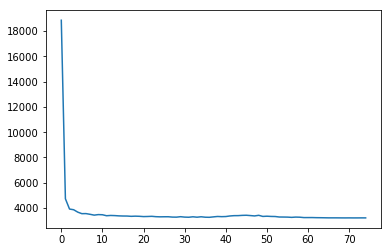

In [31]:

def main():

    hidden_layer_sizes = [400,300,100,50,20]
    neural_network = NeuralNetwork(hidden_layer_sizes = hidden_layer_sizes,
                                   dataset=load_dataset,
                                   )
    neural_network.fit()


if __name__ == '__main__':
    main()
